In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import pqcd

from scipy.integrate import cumulative_trapezoid
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    dyn_per_square_cm_to_GeV_per_cubic_femtometer,
    nsat
    )

Modify the default crust model

In [2]:
crust = pd.read_csv('../make-agnostic-processes/ingo-bps-with-cs2c2.csv')

In [3]:
crust

,baryon_density,pressurec2,energy_densityc2,cs2c2
0,6.690488e+00,1.123602e-13,7.757621e+00,1.694600e-11
1,7.911502e+00,1.123602e-12,7.817296e+00,1.355688e-10
2,7.961680e+00,1.123602e-11,7.857078e+00,3.304493e-10
3,8.212574e+00,1.123602e-10,8.105720e+00,3.831341e-10
4,1.169163e+01,1.346106e-09,1.153698e+01,1.670024e-09
...,...,...,...,...
73,1.070478e+14,4.951233e+11,1.079919e+14,7.578690e-03
74,1.137383e+14,5.478749e+11,1.147740e+14,7.983989e-03
75,1.204288e+14,6.034447e+11,1.215592e+14,8.402345e-03
76,1.271193e+14,6.619255e+11,1.283475e+14,8.781323e-03


In [4]:
pressurec2 = crust['pressurec2'].values
energy_densityc2 = crust['energy_densityc2'].values
baryon_density = crust['baryon_density'].values

In [5]:
I = cumulative_trapezoid(
    pressurec2/(energy_densityc2 + pressurec2), 
    x=np.log(energy_densityc2), 
    initial=0
    )

In [6]:
baryon_density_modified = energy_densityc2*np.exp(-I)

In [7]:
cs2c2_modified = np.gradient(pressurec2, energy_densityc2)

In [8]:
crust_modified = pd.DataFrame({
    'baryon_density': baryon_density_modified,
    'pressurec2': pressurec2,
    'energy_densityc2': energy_densityc2,
    'cs2c2': cs2c2_modified
    })

In [9]:
crust_modified

,baryon_density,pressurec2,energy_densityc2,cs2c2
0,7.757621e+00,1.123602e-13,7.757621e+00,1.694600e-11
1,7.817296e+00,1.123602e-12,7.817296e+00,1.592937e-10
2,7.857078e+00,1.123602e-11,7.857078e+00,2.752282e-10
3,8.105720e+00,1.123602e-10,8.105720e+00,4.035215e-10
4,1.153698e+01,1.346106e-09,1.153698e+01,1.455585e-09
...,...,...,...,...
73,1.060385e+14,4.951233e+11,1.079919e+14,7.578643e-03
74,1.126659e+14,5.478749e+11,1.147740e+14,7.983941e-03
75,1.192933e+14,6.034447e+11,1.215592e+14,8.402295e-03
76,1.259207e+14,6.619255e+11,1.283475e+14,8.781285e-03


In [10]:
crust_modified.to_csv(
    '../make-agnostic-processes/ingo-bps-with-cs2c2-modified.csv', 
    index=False, 
    float_format='%.18e'
    )

Inspect the modified crust model

In [11]:
crust = pd.read_csv('../make-agnostic-processes/ingo-bps-with-cs2c2-modified.csv')

In [12]:
crust_pressure = to_GeV_per_cubic_femtometre(crust.pressurec2)
crust_energy_density = to_GeV_per_cubic_femtometre(crust.energy_densityc2)
crust_number_density = to_nucleons_per_cubic_femtometre(crust.baryon_density)

crust_chemical_potential = (crust_energy_density+crust_pressure)/crust_number_density

In [13]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values for chiEFT
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

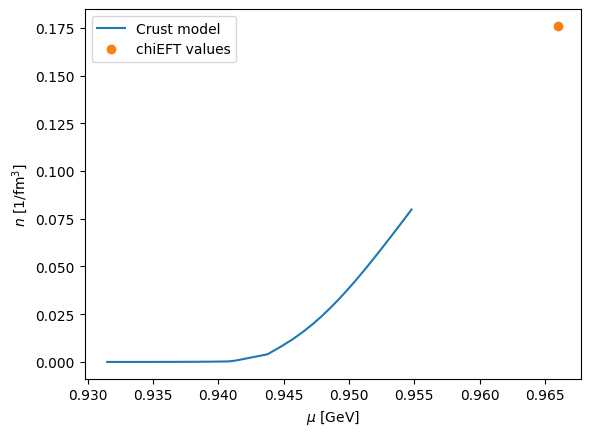

In [14]:
fig, ax = plt.subplots()

ax.plot(crust_chemical_potential, crust_number_density, label='Crust model')
ax.plot(muL, nL, 'o', label='chiEFT values')

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend();

In [15]:
# in http://arxiv.org/abs/1910.09740 its stated that p_ref = 5.4e31 dyn/cm^2,
# which is the pressure they force the GP to approach phi = 6 (i.e., they're
# trying to roughly match some known low-pressure physics)
p_ref = dyn_per_square_cm_to_GeV_per_cubic_femtometer(5.4e31)
p_ref

3.37068e-05

In [16]:
# We modified this to be a higher value in the new GP
p_ref_new = to_GeV_per_cubic_femtometre(3e11)
p_ref_new

0.0001682876581141336

In [17]:
# The index where this reference pressure is in the crust array
p_ref_new_index = np.argmin(abs(crust_pressure-p_ref_new))
p_ref_new_index

69

In [18]:
len(crust_pressure)

78

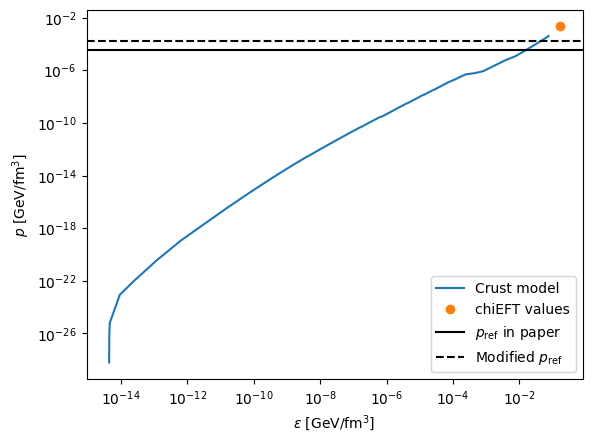

In [19]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(crust_energy_density, crust_pressure, label='Crust model')
ax.plot(epsilonL, pL, 'o', label='chiEFT values')
ax.axhline(p_ref, c='k', label='$p_\mathrm{ref}$ in paper')
ax.axhline(p_ref_new, c='k', linestyle='--', label='Modified $p_\mathrm{ref}$')

ax.set_xlabel(r'$\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')

ax.legend();

Take an example set 12 draw which was stitched to this crust:

In [20]:
file_path = '../data/eos-draws-modified/12/margagn/DRAWmod1000-000000/eos-draw-000005.csv'

eos = pd.read_csv(file_path)

eos_pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
eos_energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
eos_number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

eos_chemical_potential = (eos_energy_density+eos_pressure)/eos_number_density

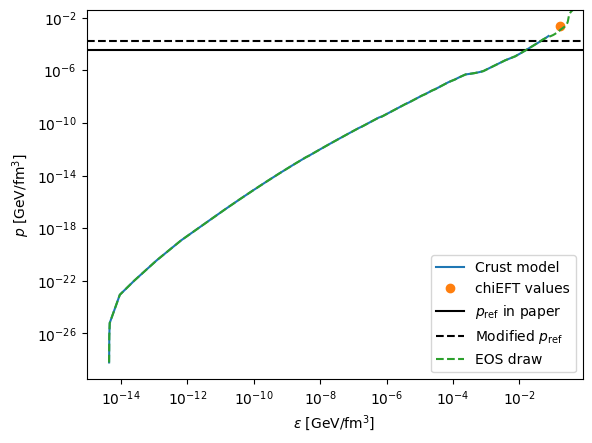

In [21]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(crust_energy_density, crust_pressure, label='Crust model')
ax.plot(epsilonL, pL, 'o', label='chiEFT values')
ax.axhline(p_ref, c='k', label='$p_\mathrm{ref}$ in paper')
ax.axhline(p_ref_new, c='k', linestyle='--', label='Modified $p_\mathrm{ref}$')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.plot(eos_energy_density, eos_pressure, linestyle='--', label='EOS draw')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')

ax.legend();

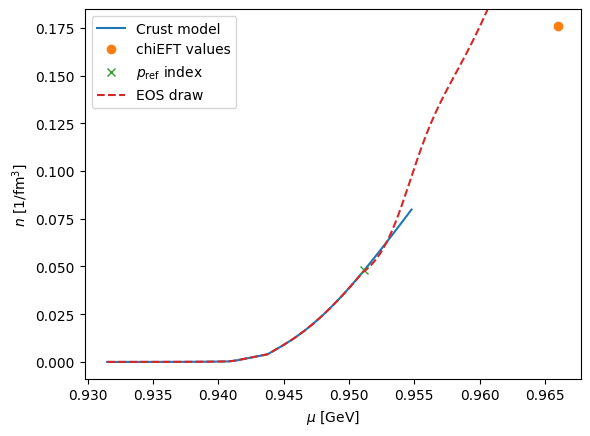

In [22]:
fig, ax = plt.subplots()

ax.plot(crust_chemical_potential, crust_number_density, label='Crust model')
ax.plot(muL, nL, 'o', label='chiEFT values')
ax.plot(
    crust_chemical_potential[p_ref_new_index], 
    crust_number_density[p_ref_new_index], 
    'x', 
    label='$p_\mathrm{ref}$ index'
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.plot(eos_chemical_potential, eos_number_density, linestyle='--', label='EOS draw')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend();